# Intro
Refer to one of classical classification problems - Potato leaf disease recognition and try to address it using on of Machine Learning methods.

# Import libraries and tools

In [2]:
# Import libraries and tools
# Data preprocessing and linear algebra
import os, re, random
from os.path import join
import zipfile
from pathlib import Path
import shutil
from sklearn.datasets import load_files
import pandas as pd
import numpy as np
np.random.seed(2)

# Visualisation
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

# Tools for cross-validation, error calculation
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import itertools
from keras.utils.np_utils import to_categorical

# Machine Learning
from keras.models import Model
from keras.models import Sequential
from keras import layers
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.layers import MaxPooling2D, GlobalAveragePooling2D, Activation
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras import optimizers
from tensorflow.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Data load

**Images are sorted into folders according to classes.**   
For example, images of cars - in the folder "Cars", images of trains - in the folder "Trains". 


### Load images into array

In [3]:
print(os.listdir('../path_to_Dataset_main_folder/..'))

['Potato___healthy', 'Potato___Late_blight', 'Potato___Early_blight']


In [4]:
INPUT_PATH = '../path_to_Dataset_main_folder/..'
print(os.listdir(INPUT_PATH))

['Potato___healthy', 'Potato___Late_blight', 'Potato___Early_blight']


Print Name of Classes in their corresponding folders

In [5]:
img_folders = [join(INPUT_PATH, dir) for dir in os.listdir(INPUT_PATH)]
list(img_folders)

['../input/plant-leaf-disease/PLD/Potato___healthy',
 '../input/plant-leaf-disease/PLD/Potato___Late_blight',
 '../input/plant-leaf-disease/PLD/Potato___Early_blight']

In [6]:
# Load images into NumPy array
images = load_files(INPUT_PATH, random_state=42, shuffle=True)
X = np.array(images['filenames'])
y = np.array(images['target'])
labels = np.array(images['target_names'])

In [ ]:
# Remove unnecessary .pyc and .py files
pyc_file = (np.where(file==X) for file in X if file.endswith(('.pyc','.py')))
for i in pyc_file:
    X = np.delete(X, i)
    y = np.delete(y, i)

In [7]:
# Array summary
print(f'Target labels (digits) - {y}')
print(f'Target labels (names) - {labels}')
print(f'Number of uploaded images : {X.shape[0]}')

Target labels (digits) - [2 1 2 ... 1 1 0]
Target labels (names) - ['Potato___Early_blight' 'Potato___Late_blight' 'Potato___healthy']
Number of uploaded images : 2968


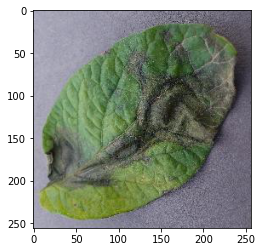

In [8]:
# Display Image using plot method
img = plt.imread('../input/plant-leaf-disease/PLD/Potato___Late_blight/Late_blight_(10).JPG')
plt.imshow(img);

In [9]:
# Check our target y variable
imgY = pd.DataFrame({'species': y})
imgY.count()

species    2968
dtype: int64

In [11]:
labels

Int64Index([0, 1, 2], dtype='int64')

In [12]:
# All algorithms have their own default image size, in my case I use 299*299 image size
image_size = 299

In [13]:
# Write images into NumPy array using sklearn's img_to_array() method
def imageLoadConverter(img_paths):
    # Load
    images = [load_img(img_path, target_size=(image_size, image_size)) for img_path in img_paths]
    # Write into array
    images_array = np.array([img_to_array(img) for img in images])
    
    return(images_array)

# Convert into NumPy array
X = np.array(imageLoadConverter(X))
# Print result
print(f'Function worked with following output (images, width, height, color): {X.shape}')

Function worked with following output (images, width, height, color): (2968, 299, 299, 3)


### Label encoding

We have 3 classes of potato lead disease and 3 labels for each of them (0,1,2,3). In order to pass them on network inputs we should make some preparation known as One-Hot Encoding, which takes a single integer and produces a vector where a single element is 1 and all other elements are 0, like [0, 1, 0].  
There are several ways in Python to do it, we will choose Keras's to_categorical() popular implementation.

In [14]:
# Convert classes in digit form
num_classes = len(np.unique(y))
print(f'Classes: {num_classes} and corresponding labels: {labels}')

Classes: 3 and corresponding labels: Int64Index([0, 1, 2], dtype='int64')


In [15]:
# One-Hot Encoding
y = to_categorical(y, num_classes)
print(y.shape)

(2968, 3)


### Split data on train and validation subsets ####

In [16]:
# Split data on train, validation and test subsets
# Using 10% or 20% from train data is classical approach

# First, split X into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=2)

# Second, split test into test and validation subsets in equal proportion
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.3, shuffle=True, random_state=2)

In [17]:
# Count number of elements in subsets
total_X_train = X_train.shape[0]
total_X_val = X_val.shape[0]
total_X_test = X_test.shape[0]

In [18]:
print(f'Train: {total_X_train}')
print(f'Validation: {total_X_val}')
print(f'Test: {total_X_test}')

Train: 2077
Validation: 623
Test: 268


In [19]:
# Delete X since it will not be needed further
del X

# Machine learning

### Model choose

Model choosing is interal part of Machine learning, I have tested my dataset by training hrough various algorithms, like: **Inception V3** which is used in this notebook, but I delievered all used algorithms code in Models.py file

### Model implementation

In [20]:
# By default, the InceptionV3 model expects images as input with the size 150x150 px with 3 channels
input_shape = (image_size, image_size, 3)

In [21]:
# Define model constants
batch_size = 8
epochs = 50
result_root = './Results' 

In [1]:
# Removing if already result folder exist
import shutil
shutil.rmtree("/kaggle/working/Results/")

Define our pre-trained model, downloading weights from Imagenet or download local weight file formated as **".h5"**.

**Case 1:** pre_trained_model = InceptionV3(input_shape = input_shape, include_top = False, weights = 'imagenet')

**Case 2:** local_weights = "../Path_to_weight_file/.."
pre_trained_model = InceptionV3(input_shape = input_shape, include_top = False, weights = local_weights)

* # Model Selection start

1. Step:1

In [23]:
pre_trained_model = InceptionV3(
    include_top=False,
    weights='imagenet', # Weightfile 
    input_shape=(299, 299, 3))

A few words about models parameters.  
**input_shape:** self-descriptive, defined earlier as images with, height and color code;  
**include_top = False:** we are going to use all the layers in the model except for the last fully connected layer as it is specific to the ImageNet competition;  
**weights = 'imagenet':** download pre-trained weights trained on Imagenet extra-big dataset.  
**weights = None**: load pure model and then upload weights from local machine.


In [ ]:
# Print pre_trained_models summary table
# print(pre_trained_model.summary())

In [24]:
# Print number of models layers
len(pre_trained_model.layers)

311

In [25]:
# Set layers to be not trainable since they are already are
for layer in pre_trained_model.layers:
     layer.trainable = False

Pre-trained model goes without top and output layers, we should specify them manually.

Usually Flatten() or GlobalAveragePoolingXD() layers are placed at the end of the CNN to get a shape that works with dense layers. 

**Flattening** a tensor means to remove all of the dimensions except for one. 

**GlobalAveragePooling** is a methodology used for better representation of your vector. It can be 1D/2D/3D. The main idea is to pool the data by averaging it (GlobalAveragePooling) or picking maximum value (GlobalMaxPooling). Padding is required to take the corner cases into the account.

In [26]:
# Add custom layers
x = pre_trained_model.output
# Add Pooling layer
x = Flatten()(x)
# Add a fully connected layer with 1024 nodes and ReLU activation
x = Dense(1024, activation="relu")(x)
# Add a dropout with rate 0.5
x = Dropout(0.5)(x)
# Specify final output layer with SoftMax activation
predictions = Dense(3, activation="softmax")(x)

A few notes about dropout rate. We empyrically choosed 0,2 rate since typical 0,5 given less accuracy. A good and gentle dropout rate tuning in my case is 0.5. Because the model can't goes for underfitting or overfitting

In [27]:
pre_trained_model.input
predictions

<KerasTensor: shape=(None, 299, 299, 3) dtype=float32 (created by layer 'input_2')>

In [29]:
# Build the final model 
final_model = Model(inputs=pre_trained_model.input, 
                        outputs=predictions
                       )

In [30]:
import tensorflow as tf
# Compile model
final_model.compile(loss='categorical_crossentropy',
                        optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9),
                        metrics=['accuracy']
                       )

### DataGenerators

#### Training DataGenerator

In [31]:
# Implement train ImageDataGenerator and specify some preprocessing
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    width_shift_range=0.1,
    height_shift_range=0.1
)

In [32]:
# Upload and peprocess images
train_generator = train_datagen.flow(
        X_train, y_train, 
        batch_size=batch_size,
        shuffle=False)  

#### Validation DataGenerator

In [33]:
# Implement validation ImageDataGenerator
validation_datagen = ImageDataGenerator(
    rescale=1./255
)

In [34]:
validation_generator = validation_datagen.flow(
        X_val, y_val,
        batch_size=batch_size,
        shuffle=False) 

#### Test DataGenerator

In [35]:
test_datagen = ImageDataGenerator(
    rescale=1./255
)

In [36]:
test_generator = test_datagen.flow(
        X_test, y_test,
        batch_size=batch_size,
        shuffle=False
)

### Callbacks

Before we start training our model we should care about avoiding of model overfitting. Callback functions will be very helpfull.  

> A callback is a set of functions to be applied at given stages of the training procedure. You can use callbacks to get a view on internal states and statistics of the model during training.

There are two useful ones: **Early Stop** (Keras EarlyStop() method) and **Learning Rate Reduction** (Keras ReduceLROnPlateau() method). 


#### Early Stop

In [37]:
# Stop model learning after 10 epochs in which val_loss value not decreased
early_stop = EarlyStopping(patience=10, 
                          verbose=1, 
                          mode='auto'
                         )

#### Learning Rate Reduction

In [38]:
# Reduce the learning rate when accuracy, for example, not increase for two continuous steps
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001
                                           )

In [39]:
# Save callbacks
callbacks = [early_stop, learning_rate_reduction]
callbacks

### Model fit

In [ ]:
hist = final_model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_X_val//batch_size,
    steps_per_epoch=total_X_train//batch_size,
    callbacks=callbacks
)
final_model.save(os.path.join(result_root, 'model_final.h5'))

We obtain accuracy 98.89 %. Good result. Howewer, it can be improved by playing with model hyperpaameters.

### Visualize accuracy and loss after model fit

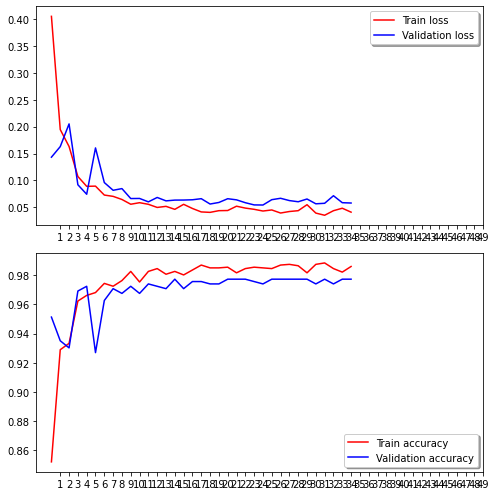

In [41]:
# Plot accuracy and loss curves
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 7))

ax1.plot(hist.history['loss'], color='r', label="Train loss")
ax1.plot(hist.history['val_loss'], color='b', label="Validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
legend = ax1.legend(loc='best', shadow=True)

ax2.plot(hist.history['accuracy'], color='r', label="Train accuracy")
ax2.plot(hist.history['val_accuracy'], color='b',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))
legend = ax2.legend(loc='best', shadow=True)

plt.tight_layout()
plt.show()

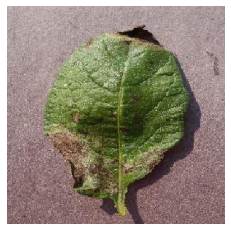

Predicted Class :  1
Actual Class :  Potato___Late_blight
Confidence :  99.9 %
_____________________________________________________________


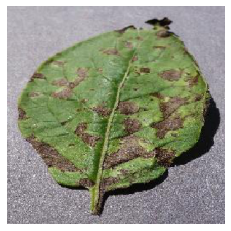

Predicted Class :  0
Actual Class :  Potato___Early_blight
Confidence :  95.72 %
_____________________________________________________________


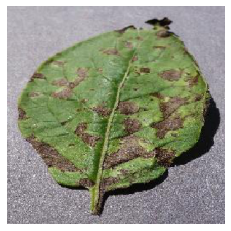

Predicted Class :  0
Actual Class :  Potato___Early_blight
Confidence :  95.72 %
_____________________________________________________________


In [45]:
# Prediction on random data which is not used in Train/Val/Test.
from keras.models import load_model
from keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import os

def load_image(img_path, show = False) :
    img = image.load_img(img_path, target_size = (299, 299))
    img_tensor = image.img_to_array(img)                    # (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis = 0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
    img_tensor /= 255.                                      # imshow expects values in the range [0, 1]

    if show :
        plt.imshow(img_tensor[0])                           
        plt.axis('off')
        plt.show()

    return img_tensor

def get_labels(test_path) : 
    # getting class labels
    from glob import glob

    class_names = labels
#     test_path = test_path + '/*'
#     for i in glob(test_path) :  # Reads all the folders in which images are present
#         class_names.append(i.split('/')[-1])

    # return dict(zip(class_names, range(len(class_names))))    # return dictionary containing class name and numeric label.
    return sorted(class_names)

if __name__ == "__main__":
    # load model
    model = load_model("./Results/model_final.h5", compile = False)

    # image path
    img1 = '../input/plant-leaf-disease/PLD/Potato___Late_blight/Late_blight_(1).JPG'   
    img2 = '../input/plant-leaf-disease/PLD/Potato___Early_blight/Early_blight_(101).JPG'
    img3 = '../input/plant-leaf-disease/PLD/Potato___Early_blight/Early_blight_(101).JPG'
#     img4 = '../input/plant-leaf-disease/PLD/Potato___Late_blight/Late_blight_(103).JPG'
#     img5 = '../input/plant-leaf-disease/PLD/Potato___healthy/Healthy_(1).JPG'
#     img6 = '../input/plant-leaf-disease/PLD/Potato___healthy/Healthy_(102).JPG'
#     img7 = '../input/plant-leaf-disease/PLD/Potato___healthy/Healthy_(105).JPG'
#     img8 = '../input/plant-leaf-disease/PLD/Potato___healthy/Healthy_(106).JPG'
#     img9 = '../input/plant-leaf-disease/PLD/Potato___Early_blight/Early_blight_(108).JPG'
    
    class_names = get_labels('../path_to_Dataset_main_folder/..')
    for i in [img1, img2, img3] : 
        new_image = load_image(i, show = True)
        y_proba = model.predict(new_image)
        confidence = round(100 * (np.max(y_proba[0])), 2)
        print('Predicted Class : ', class_names[np.argmax(y_proba)])
        print('Actual Class : ', i.split('/')[-2])
        print('Confidence : ', confidence, '%')
        print('_____________________________________________________________')

### Predict on validation data

In [46]:
# Predict on validation X_val_resnet
y_pred_val = final_model.predict_generator(validation_generator)

In [47]:
# Prepare y_true and y_pred on validation by taking the most likely class
y_true_val = y_val.argmax(axis=1)
y_pred_val = y_pred_val.argmax(axis=1)

In [48]:
# Check datatypes
print(f'y_true datatype: {y_true_val.dtype}')
print(f'y_pred datatype: {y_pred_val.dtype}')

y_true datatype: int64
y_pred datatype: int64


In [49]:
# Evaluate on validation dataset
loss, acc = final_model.evaluate_generator(validation_generator, verbose=0)
print(f'Validation loss: {loss:.2f}%')
print(f'Validation accuracy: {acc*100:.2f}%')

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Validation loss: 0.06%
Validation accuracy: 97.59%


### Visualize prediction on validation data

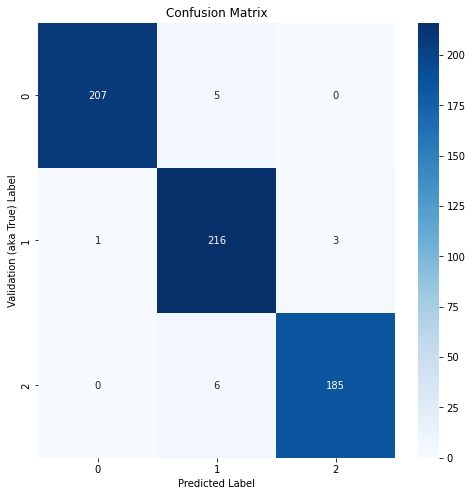

In [50]:
# Compute and plot the Confusion matrix
confusion_mtx_resnet = confusion_matrix(y_true_val, y_pred_val) 

f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx_resnet, annot=True, fmt='d', cmap=plt.cm.Blues)
plt.xlabel("Predicted Label")
plt.ylabel("Validation (aka True) Label")
plt.title("Confusion Matrix")
plt.show()

### Predict on test data

In [51]:
samples = total_X_test

In [52]:
predict = final_model.predict_generator(test_generator, steps=np.ceil(samples/batch_size))

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [53]:
predict.shape

(268, 3)

In [54]:
X_test.shape

(268, 299, 299, 3)

In [55]:
# Evaluate on test dataset
loss, acc = final_model.evaluate_generator(test_generator, verbose=0)
print(f'Test loss: {loss:.2f}%')
print(f'Test accuracy: {acc*100:.2f}%')

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Test loss: 0.07%
Test accuracy: 97.01%


In [56]:
# Get most likely class as y_pred and y_test
y_pred = predict.argmax(axis=1)
y_true = y_test.argmax(axis=1)


In [57]:
# Show classification report
print(metrics.classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98        98
           1       0.92      0.99      0.95        82
           2       1.00      0.95      0.98        88

    accuracy                           0.97       268
   macro avg       0.97      0.97      0.97       268
weighted avg       0.97      0.97      0.97       268



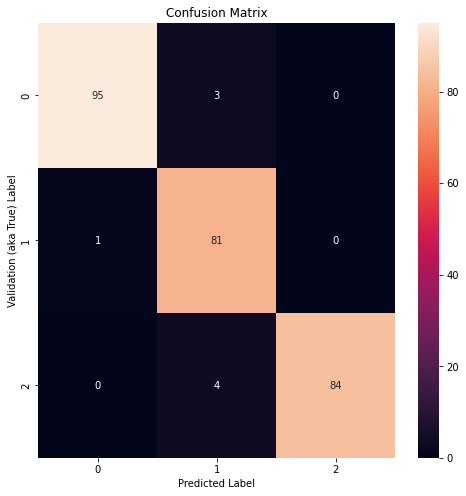

In [58]:
# Compute and plot the Confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred) 

f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True)
plt.xlabel("Predicted Label")
plt.ylabel("Validation (aka True) Label")
plt.title("Confusion Matrix")
plt.show()